Extract feature from Functional brain networks reflect spatial and temporal autocorrelation (Shinn, NN, 2023)

In [1]:
import sys
sys.path.append("../mypkg")

In [3]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, get_ball_cor
from utils.colors import qual_cmap

In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [6]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [7]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
def _get_fc(ts, is_fisher=True):
    """Get FC from ts, including 
        1. Pearsons'r 
        2. fisher transform
        3. abs value
    """
    fc = np.corrcoef(ts)
    fc = fc - np.diag(np.diag(fc))
    return fc

    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

In [14]:
def reg_R_fn(x, y):
    """Calculate pearons'r in batch, for both numpy and torch
    Args:
    x: torch.Tensor, shape (batch_size, num_sps)
    y: torch.Tensor, shape (batch_size, num_sps)
    Returns:
    corrs: torch.Tensor, shape (batch_size,)                                                                                                                               
    """
    assert x.shape == y.shape, "x and y should have the same shape"
    x_mean = x.mean(axis=-1, keepdims=True)
    y_mean = y.mean(axis=-1, keepdims=True)
    num = ((x- x_mean)*(y-y_mean)).sum(axis=-1)
    den = np.sqrt(((x- x_mean)**2).sum(axis=-1)*((y-y_mean)**2).sum(axis=-1))
    corrs = num/den
    return corrs

## Load data and params

In [9]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");

# some parameters

num_rois = 246 # the BNA has 246 regions
num_sps = 321

# Get features

## TA

In [8]:
def _get_TAs(ts):
    """ts: d x n """
    ts1 = ts[:, :-1]
    ts2 = ts[:, 1:]
    return reg_R_fn(ts1, ts2)

TAs = []
for sub_ix in range(1, num_sps+1):
    ts = _load_data(sub_ix)[:num_rois]
    ts = _preprocess_ts(ts)
    cur_TAs = _get_TAs(ts)
    TAs.append(cur_TAs)

save_pkl(RES_ROOT/"TAs.pkl", TAs, is_force=0)


Save to /MyResearch/jesse_data/notebooks/../mypkg/../results/TAs.pkl


In [15]:
ballTAs = []
for sub_ix in trange(1, num_sps+1):
    ts = _load_data(sub_ix)[:num_rois]
    ts = _preprocess_ts(ts)
    ts1 = ts.T[:-1]
    ts2 = ts.T[1:]
    ballTAs.append(get_ball_cor(ts1, ts2))

save_pkl(RES_ROOT/"ballTAs.pkl", ballTAs, is_force=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:18<00:00, 17.12it/s]

Save to /MyResearch/jesse_data/notebooks/../mypkg/../results/ballTAs.pkl


## SA

<AxesSubplot:>

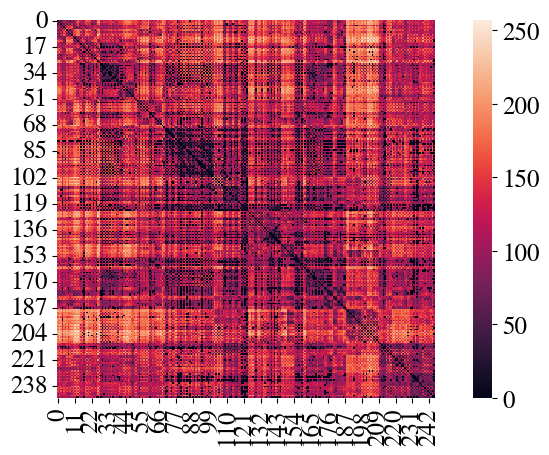

In [26]:
ui = np.triu_indices(num_rois, 1)
dist_mat = loadmat(DATA_ROOT/"SC_HC_BN_template_nature_order.mat")["Dist_template"]
#idxs = np.concatenate([np.arange(0, 246, 2), np.arange(1, 246, 2)])
#dist_mat = dist_mat[idxs][:, idxs]
sns.heatmap(dist_mat, square=1)



In [33]:
# some fn to get SA
# optimization
from scipy.optimize import minimize
def _reg_yx(vec, bins, bin_idxs):
    yv = []
    xv = []
    for i in np.sort(list(set(bin_idxs))):
        xv.append(bins[i-1])
        yv.append(vec[bin_idxs==i].mean())
    return np.array(xv), np.array(yv)
# opt fn 
def _obj_f(x, data):
    """min obj_f
    """
    xv, yv = data
    sa_inf, sa_lam = x 
    left = (yv-sa_inf)/(1-sa_inf)
    right = np.exp(-xv/sa_lam)
    return np.sum((left-right)**2)
def _minimize(fun, x0s, bounds, args):
    """A simple wrapper of minimize to allow multiple initial pts
    """
    fn_v = []
    xs = []
    for x0 in x0s:
        res = minimize(fun, x0, bounds=bounds, args=args)
        xs.append(res.x)
        fn_v.append(res.fun)
    return xs[np.argmin(fn_v)]
def _get_SA(fc, dist_mat, nbin=10):
    dist_vec = dist_mat[ui];
    bins = np.arange(np.min(dist_vec),  np.max(dist_vec), nbin)
    bin_idxs = np.digitize(dist_vec, bins);
    fc_vec = fc[ui]
        
    # initial value and bds
    # (sa_inf, sa_lam)
    x0s = ([-0.5, 25], [0, 50], [0.5, 75])
    eps = 1e-5
    bounds = [(-1+eps, 1-eps), (0+eps, 100)]

    # get fitting
    xv, yv = _reg_yx(fc_vec, bins, bin_idxs);
    res = _minimize(_obj_f, x0s, bounds=bounds, args=([xv, yv], ))
    return res

In [41]:
SAs = []
for sub_ix in trange(1, num_sps+1):
    ts = _load_data(sub_ix)[:num_rois]
    ts = _preprocess_ts(ts)
    fc = _get_fc(ts)
    cur_SA = _get_SA(fc, dist_mat, nbin=5)
    SAs.append(cur_SA)
save_pkl(RES_ROOT/"SAs.pkl", SAs, is_force=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:09<00:00, 33.28it/s]

Save to /MyResearch/jesse_data/notebooks/../mypkg/../results/SAs.pkl


In [27]:
# get ball SA
bcorFCs = load_pkl(RES_ROOT/"bcorFCs.pkl");

Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/bcorFCs.pkl


In [57]:
# reg FC vs ball FC
std_fn = lambda x: (x-np.mean(x))/np.std(x)
sub_ix = 2
nbin = 5 
yvs = []
byvs = []
for sub_ix in trange(1, num_sps+1):
    bfc = bcorFCs[sub_ix-1]
    ts = _load_data(sub_ix)[:num_rois]
    ts = _preprocess_ts(ts)
    fc = _get_fc(ts)
    
    dist_vec = dist_mat[ui];
    bins = np.arange(np.min(dist_vec),  np.max(dist_vec), nbin)
    bin_idxs = np.digitize(dist_vec, bins);
    
    
    bfc_vec = bfc[ui]
    fc_vec = fc[ui]
    xv, yv = _reg_yx(fc_vec, bins, bin_idxs);
    bxv, byv = _reg_yx(bfc_vec, bins, bin_idxs);
    yvs.append(yv)
    byvs.append(byv)

yvs = np.array(yvs)
byvs = np.array(byvs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:04<00:00, 66.51it/s]


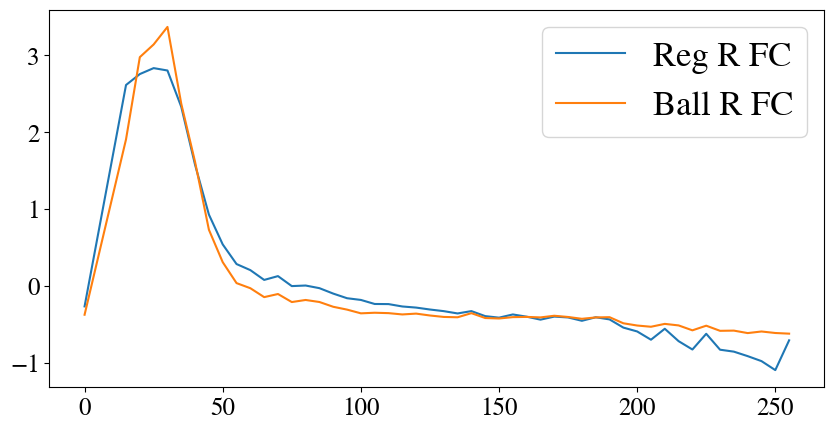

In [58]:
plt.plot(xv, std_fn(yvs.mean(axis=0)), label="Reg R FC")
plt.plot(bxv, std_fn(byvs.mean(axis=0)), label="Ball R FC")
plt.legend()

In [59]:
ballSAs = []
for sub_ix in trange(1, num_sps+1):
    fc = bcorFCs[sub_ix-1]
    cur_SA = _get_SA(fc, dist_mat, nbin=5)
    ballSAs.append(cur_SA)
save_pkl(RES_ROOT/"ballSAs.pkl", ballSAs, is_force=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:07<00:00, 45.65it/s]

Save to /MyResearch/jesse_data/notebooks/../mypkg/../results/ballSAs.pkl


# Analyasis

In [17]:
from scipy.stats import f_oneway, ttest_ind 

In [60]:
TAs = load_pkl(RES_ROOT/"TAs.pkl");
SAs = load_pkl(RES_ROOT/"SAs.pkl");
bTAs = load_pkl(RES_ROOT/"ballTAs.pkl");
bSAs = load_pkl(RES_ROOT/"ballSAs.pkl");

Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/TAs.pkl
Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/SAs.pkl
Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/ballTAs.pkl
Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/ballSAs.pkl


In [72]:
scipy.stats.pearsonr(np.array(SAs)[:, 1], np.array(bSAs)[:, 1])

(0.33864900471456155, 4.702386984052635e-10)

In [19]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

In [21]:
metric = "SA-inf"
metrics = np.array([SA[0] for SA in SAs])

res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
_get_test_tb(res_df)

Metric is SA-inf


Test,Pval,Effect size
*AD vs HC,0.009,-0.386
bvFTD vs HC,0.060,-0.348
*CBS vs HC,0.001,-0.691
nfvPPA vs HC,0.123,-0.305
svPPA vs HC,0.291,0.203
*Dementia vs HC,0.014,-0.294
*ANOVA,0.004,


In [22]:
metric = "SA-lam"
metrics = np.array([SA[1] for SA in SAs])

res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
_get_test_tb(res_df)

Metric is SA-lam


Test,Pval,Effect size
AD vs HC,0.087,0.254
bvFTD vs HC,0.463,0.136
CBS vs HC,0.154,0.309
nfvPPA vs HC,0.709,0.074
svPPA vs HC,0.059,-0.362
Dementia vs HC,0.343,0.114
ANOVA,0.107,


In [67]:
metric = "bSA-inf"
metrics = np.array([SA[0] for SA in bSAs])

res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
_get_test_tb(res_df)

Metric is bSA-inf


Test,Pval,Effect size
AD vs HC,0.466,-0.109
bvFTD vs HC,0.602,-0.097
CBS vs HC,0.056,-0.413
nfvPPA vs HC,0.153,-0.283
svPPA vs HC,0.541,-0.118
Dementia vs HC,0.120,-0.187
ANOVA,0.346,


In [68]:
metric = "bSA-lam"
metrics = np.array([SA[0] for SA in bSAs])

res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
_get_test_tb(res_df)

Metric is bSA-lam


Test,Pval,Effect size
AD vs HC,0.466,-0.109
bvFTD vs HC,0.602,-0.097
CBS vs HC,0.056,-0.413
nfvPPA vs HC,0.153,-0.283
svPPA vs HC,0.541,-0.118
Dementia vs HC,0.120,-0.187
ANOVA,0.346,


In [23]:
metric = "mTA"
metrics = np.array([np.mean(TA) for TA in TAs])

res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
_get_test_tb(res_df)

Metric is mTA


Test,Pval,Effect size
AD vs HC,0.822,-0.034
*bvFTD vs HC,0.024,-0.414
CBS vs HC,0.900,0.027
nfvPPA vs HC,0.412,-0.163
svPPA vs HC,0.801,0.049
Dementia vs HC,0.400,-0.101
ANOVA,0.265,


In [25]:
metric = "ballTA"
metrics = np.array(bTAs)

res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
_get_test_tb(res_df)

Metric is ballTA


Test,Pval,Effect size
*AD vs HC,0.008,0.393
bvFTD vs HC,0.167,0.256
CBS vs HC,0.528,0.137
nfvPPA vs HC,0.375,0.176
*svPPA vs HC,0.001,0.610
*Dementia vs HC,0.006,0.330
*ANOVA,0.027,


In [61]:
cols = qual_cmap(len(set(diag_labs)))


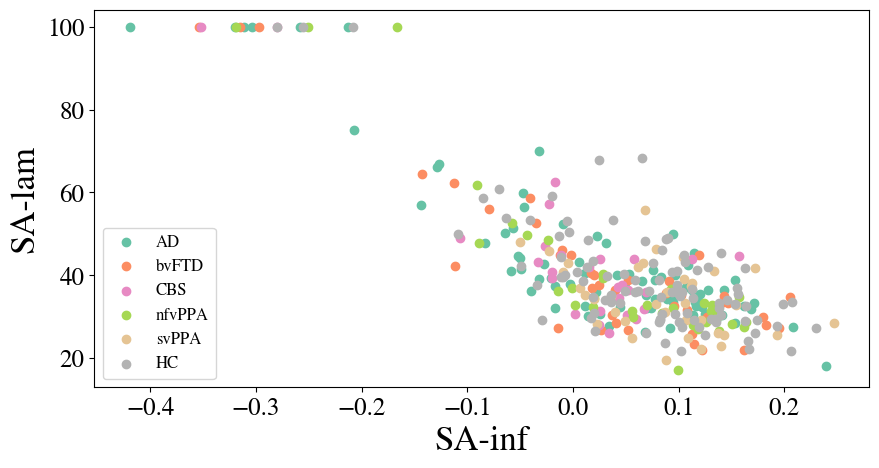

In [63]:
metricss = np.array(SAs)
#for ix in [1, 6]:
for ix in range(1, len(set(diag_labs))+1):
    plt.scatter(x=metricss[diag_labs==ix, 0], y=metricss[diag_labs==ix, 1], color=cols[ix-1], label=diag_lab_mapping[ix])
plt.xlabel("SA-inf")
plt.ylabel("SA-lam")
plt.legend(loc="lower left", fontsize=12)

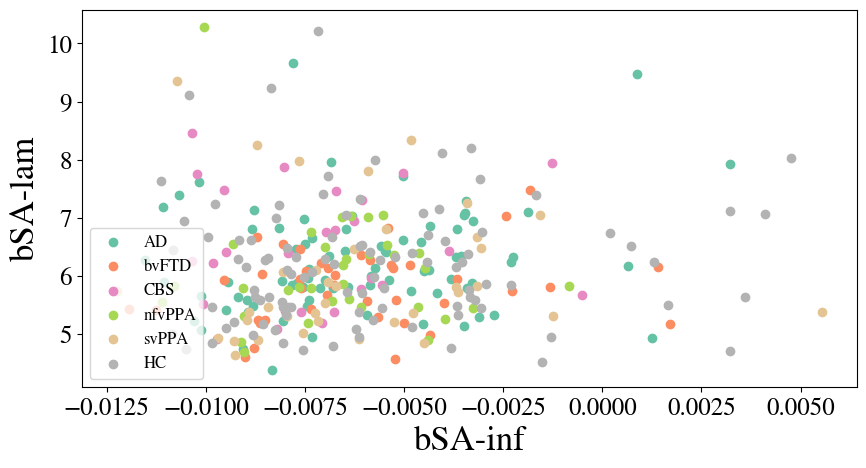

In [69]:
metricss = np.array(bSAs)
#for ix in [1, 6]:
for ix in range(1, len(set(diag_labs))+1):
    plt.scatter(x=metricss[diag_labs==ix, 0], y=metricss[diag_labs==ix, 1], color=cols[ix-1], label=diag_lab_mapping[ix])
plt.xlabel("bSA-inf")
plt.ylabel("bSA-lam")
plt.legend(loc="lower left", fontsize=12)

Text(0.5, 0, 'ROI')

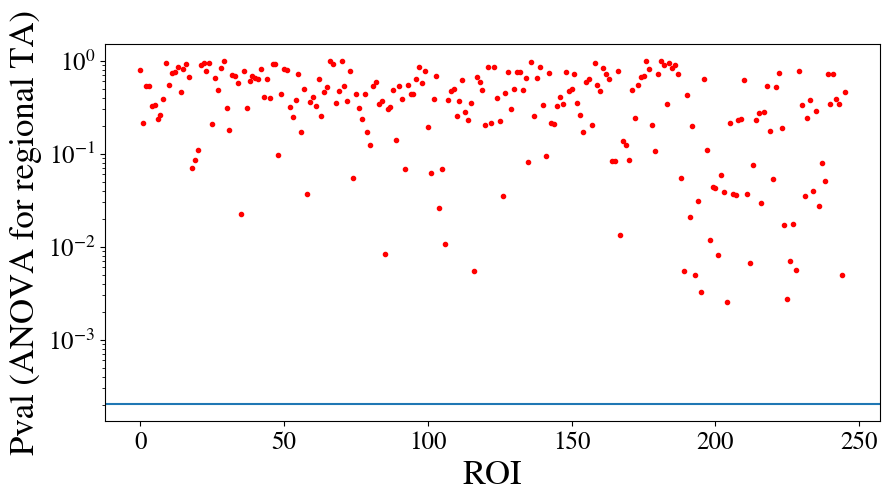

In [16]:
TAs_arr = np.array(TAs)
pvals = []
tpvals = []
for roi_ix in range(num_rois):
    metrics = TAs_arr[:, roi_ix]
    metric_grp = [metrics[diag_labs==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    metric_t = [metrics[diag_labs==grp_ix] for grp_ix in [1, 6]]
    ttest_res = ttest_ind(*metric_t)
    pvals.append(anova_res.pvalue)
    tpvals.append(ttest_res.pvalue)
pvals = np.array(pvals)
tpvals = np.array(tpvals)

plt.plot(pvals, "r.")
plt.yscale("log")
plt.axhline(y=0.05/num_rois)
plt.ylabel("Pval (ANOVA for regional TA)")
plt.xlabel("ROI")

Text(0.5, 0, 'ROI')

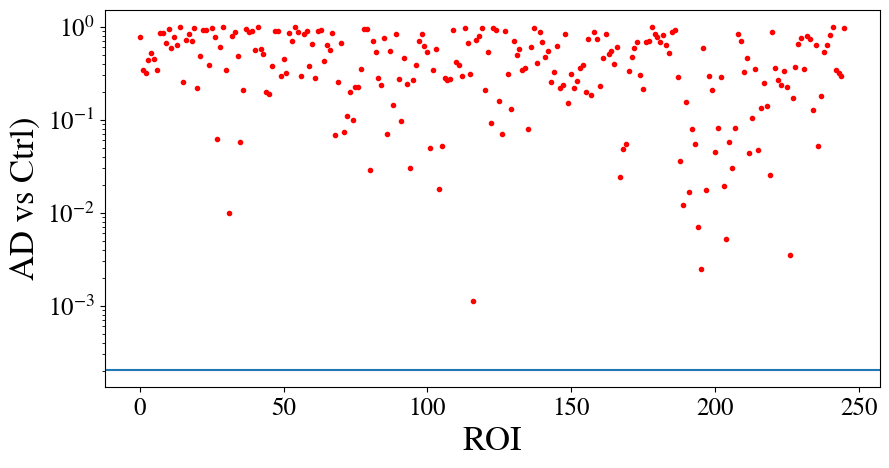

In [17]:
plt.plot(tpvals, "r.")
plt.yscale("log")
plt.axhline(y=0.05/num_rois)
plt.ylabel("AD vs Ctrl)")
plt.xlabel("ROI")